# Computation of the Deformation
# of Ferromagnetic Material Taking Into Account
# Magnetic Forces and Magnetostriction

To compute the deformation of ferromagnetic material, differents force distributions can be taken into account such as total magnetic force, anisotropy and/or rotational excitation induced force, or magnetoelastic / magnetostrictive force.

To compute this latter, it is proposed to use a formulation of this force tensor on isotropic material based on the following scientific article: [L. Vandevelde, J. Gyselinck, M. A. C. De Wulf and J. A. A. Melkebeek, "Finite-element computation of the deformation of ferromagnetic material taking into account magnetic forces and magnetostriction," in IEEE Transactions on Magnetics, vol. 40, no. 2, pp. 565-568, March 2004, doi: 10.1109/TMAG.2004.824540.](https://ieeexplore.ieee.org/abstract/document/1284477)

This tutorial explains how to use the ForceTensor class in Pyleecan to get the deformation of the material, and presents a validation case. 

The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_MagnetostrictiveForces.ipynb).

# Computation on Pyleecan

## Import Pyleecan modules and machine definition

In [7]:
%matplotlib notebook

from os.path import join
import pathlib
from numpy import zeros, exp, pi, real, meshgrid, mean
from numpy.testing import assert_array_almost_equal
from SciDataTool import DataTime, VectorField, Data1D
import csv
import numpy as np
import matplotlib.pyplot as plt


from pyleecan.Classes.ForceTensor import ForceTensor
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.SolutionVector import SolutionVector

from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR


DEBUG:matplotlib.pyplot:Loaded backend nbAgg version unknown.


## Run the simulation
The electromagnetic field is solved in a 2D magnetostatic simulation using FEMM software. The material used is a Benchmark stator on which references deformation values for magnetostrictive forces are available. The "tensor" dictionnary line 28. will be useful to declare other types of force density one might want to compute.

In [8]:
# Load machine
Benchmark = load(join(DATA_DIR, "Machine", "Benchmark.json"))
# Prepare simulation
simu = Simu1(name="Benchmark_Tensor", machine=Benchmark)

simu.input = InputCurrent(
    Id_ref=0, Iq_ref=0, Ir=None, Na_tot=2 ** 6, Nt_tot=1, N0=1200
)

simu.elec = None

simu.mag = MagFEMM(
    type_BH_stator=1,  # 0 for saturated
    type_BH_rotor=1,
    is_periodicity_a=False,
    is_periodicity_t=False,
    is_get_meshsolution=True,
    is_sliding_band=False,
    # nb_worker=cpu_count(),
    Kmesh_fineness=1,
)

# Our ForceTensor class
simu.force = ForceTensor(
    is_periodicity_a=False,
    is_periodicity_t=False,
    tensor={
        "magnetostriction": True,
    },
)

# Run simulation
out = simu.run()



[10:09:33] Starting running simulation Benchmark_Tensor (machine=Benchmark)
[10:09:33] Starting Magnetic module
[10:09:36] Computing Airgap Flux in FEMM
[10:09:38] Starting Force module
[10:09:42] End of simulation Benchmark_Tensor


## Display the deformation
It should open on a new window pop-up

In [9]:
out.force.meshsolution.plot_glyph(
    label="F",
    is_point_arrow=True,
    # save_path="add a save path if you want",
)

# Validation case and code details

## Import the reference results
These are available thanks to Pr. Lieven Vandevelde from the Gand University, Belgium.

In [10]:
#CSV import 
current_workdir = str(pathlib.Path().absolute())
ref_path = current_workdir.replace("Tutorials","Tests\Data\Benchmark_model_stator_ms.csv")
with open(ref_path, "r") as file:
    reader = csv.reader(file, skipinitialspace=True)
    l1 = next(reader)
    l2 = next(reader)
    l3 = next(reader)
    nb_node = int(l2[1])
    dim = int(l2[2])
    Nt_tot = int(l2[3])
    f2 = np.zeros((nb_node, dim))
    node_number_list = []
    indices_nodes = []
    for row in reader:
        f2[int(row[0])][0] = 1000*float(row[3])
        f2[int(row[0])][1] = 1000*float(row[4])
        node_number_list.append(int(row[10]))
        indices_nodes.append(int(row[11]))

# Little trick to reshape f2 so that it can be compared to f, since Indices_Points2 isn't taken into account yet
_,_,connectivity = np.intersect1d(indices_nodes,node_number_list,return_indices=True)
f2 = f2[connectivity,:]

f2 = f2.reshape((Nt_tot,nb_node,dim))

components2 = {}
Indices_Point2 = Data1D(name="indice", values=np.array(node_number_list), is_components=True)

Time = out.force.meshsolution.solution[0].field.get_axes()[0]

fx2_data = DataTime(
    name="Nodal force 2 (x)",
    unit="N",
    symbol="Fx2",
    axes=[Time, Indices_Point2],
    values=f2[..., 0],
)
components2["comp_x"] = fx2_data

fy2_data = DataTime(
    name="Nodal force 2 (y)",
    unit="N",
    symbol="Fy2",
    axes=[Time, Indices_Point2],
    values=f2[..., 1],
)
components2["comp_y"] = fy2_data

vec_force2 = VectorField(name="Nodal forces 2", symbol="F2", components=components2)
solforce2 = SolutionVector(field=vec_force2, type_cell="node", label="F2")
out.force.meshsolution.solution.append(solforce2)



## Analyse & compare

One can firstly plot the reference deformations

In [11]:
out.force.meshsolution.plot_glyph(
    label="F2",
    is_point_arrow=True,
    # save_path="add a save path if you want",
)

To pursue further comparisons we will filter the relevant values given the following criteria : 
$$f_{node} \geq \frac{f_{max}}{1000} $$ One can see that the **mean relative error** along both axis is approximately **1.5%** which validates the algorithm.

Relative error is defined as follow :
\begin{equation}
error_x = \frac{|f_x - f_{ref,x}|}{|f_{ref,x}|}
\end{equation}


<IPython.core.display.Javascript object>


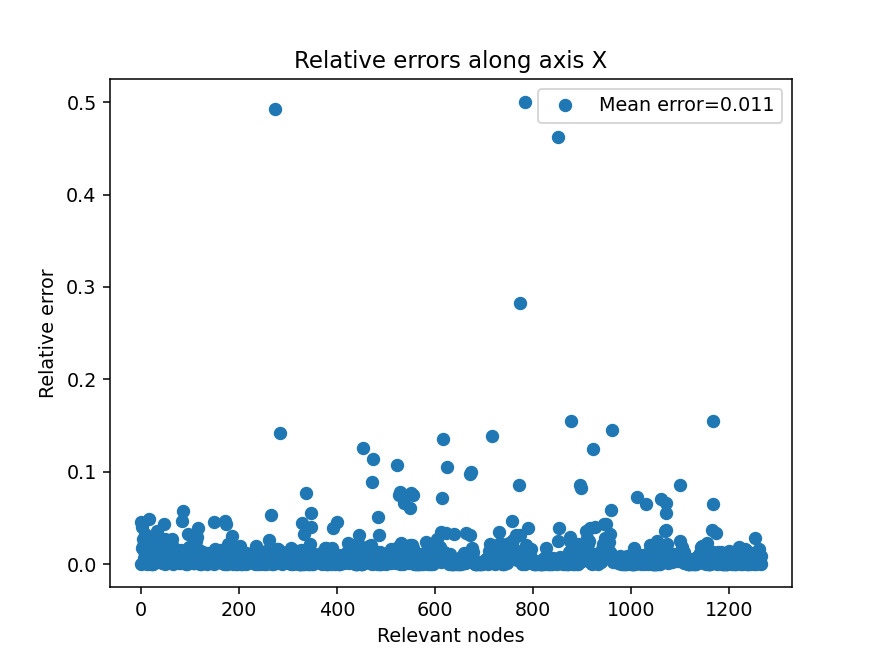

<IPython.core.display.Javascript object>


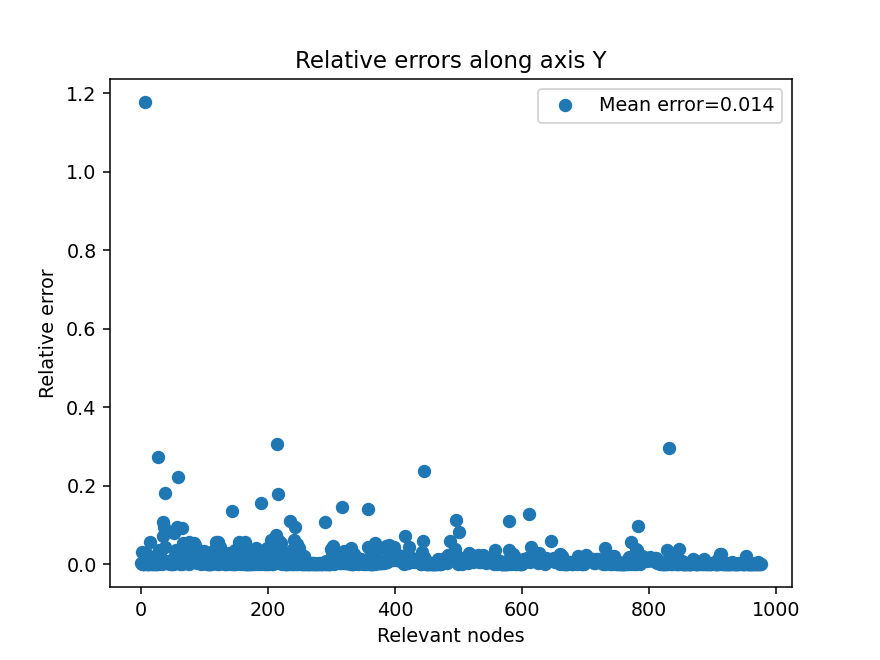

In [12]:
computed_forces_x = out.force.meshsolution.solution[0].field.components["comp_x"].values
reference_forces_x = f2[..., 0] 

computed_forces_y = out.force.meshsolution.solution[0].field.components["comp_y"].values
reference_forces_y = f2[..., 1] 


# Filter on 1e-3 * max
relevant_mask_x = reference_forces_x > 1e-3*np.max(reference_forces_x)
relevant_mask_y = reference_forces_y > 1e-3*np.max(reference_forces_y)

relevant_computed_forces_x = computed_forces_x[relevant_mask_x]
relevant_reference_forces_x = reference_forces_x[relevant_mask_x] 
relevant_computed_forces_y = computed_forces_y[relevant_mask_y]
relevant_reference_forces_y = reference_forces_y[relevant_mask_y] 


plt.figure()
mean_error_x = np.mean(np.abs(relevant_computed_forces_x-relevant_reference_forces_x)/np.abs(relevant_reference_forces_x))
plt.plot(np.arange(len(relevant_computed_forces_x)),np.abs(relevant_computed_forces_x-relevant_reference_forces_x)/np.abs(relevant_reference_forces_x),'o',label='Mean error={}'.format(np.round(mean_error_x,3)))
plt.xlabel('Relevant nodes')
plt.ylabel('Relative error')
plt.legend(loc='best')
plt.title('Relative errors along axis X')
plt.show()

plt.figure()
mean_error_y = np.mean(np.abs(relevant_computed_forces_y-relevant_reference_forces_y)/np.abs(relevant_reference_forces_y))
plt.plot(np.arange(len(relevant_computed_forces_y)),np.abs(relevant_computed_forces_y-relevant_reference_forces_y)/np.abs(relevant_reference_forces_y),'o',label='Mean error={}'.format(np.round(mean_error_y,3)))
plt.xlabel('Relevant nodes')
plt.ylabel('Relative error')
plt.legend(loc='best')
plt.title('Relative errors along axis Y')
plt.show()



It could be interesting to display the forces on **relevant nodes** that have a significatively huge error, i.e. : $$ error > 0.2 $$
It is done on the next plot based on errors along axis X, with $$ f - f_{ref} $$ being displayed on these nodes.
One can see that it happends mostly on nodes at the interface between stator and air.

In [13]:
big_diff_mask_x = np.logical_and(np.abs(computed_forces_x-reference_forces_x)/np.abs(reference_forces_x) > 0.2, np.abs(computed_forces_x-reference_forces_x)/np.abs(reference_forces_x) < 1.5)
big_diff_mask_y = np.logical_and(np.abs(computed_forces_y-reference_forces_y)/np.abs(reference_forces_y) > 0.2, np.abs(computed_forces_y-reference_forces_y)/np.abs(reference_forces_y) < 1.5)

big_diff_x = np.where(big_diff_mask_x,computed_forces_x-reference_forces_x,np.zeros(computed_forces_x.shape))
big_diff_y_x = np.where(big_diff_mask_x,computed_forces_y-reference_forces_y,np.zeros(computed_forces_y.shape))

components_diff_x = {}
fx_diff_data = DataTime(
    name="Nodal force diff x (x)",
    unit="N",
    symbol="Fxdx",
    axes=[Time, Indices_Point2],
    values=big_diff_x,
)
components_diff_x["comp_x"] = fx_diff_data

fy_diff_data = DataTime(
    name="Nodal force diff x (y)",
    unit="N",
    symbol="Fydx",
    axes=[Time, Indices_Point2],
    values=big_diff_y_x,
)
components_diff_x["comp_y"] = fx_diff_data

vec_force_dx = VectorField(name="Nodal forces dx", symbol="Fdx", components=components_diff_x)
solforce_dx = SolutionVector(field=vec_force_dx, type_cell="node", label="Fdx")
out.force.meshsolution.solution.append(solforce_dx)

out.force.meshsolution.plot_glyph(
    label="Fdx",
    is_point_arrow=True,
    # is_show_fig=True,
    # save_path=join(save_path,"magneto_plot_glyph2.png"),
)

## Code details

The gist of the physics can be found in the method element_loop, which is a loop on the element of the mesh that is called in comp_force_nodal. There, the magnetostrictive tensor is computed :

In [21]:
# if(self.tensor['magnetostriction']):
#     tme = self.comp_magnetostrictive_tensor(mue, Me, Nt_tot, polynomial_coeffs)
#     total_tensor += tme

comp_magnetostrictive_tensor uses the following defintion from the already introduced article :
$$ \alpha^c = -\alpha_1 * \mu_0 * MM - \alpha_2*\mu_0*M^2*I $$
where $\alpha_i$ depend on the material and have default values according to experimental results in the publication.

This tensor is bounded to an element since we currently work with first-order element, meaning physical values such as B,H,M are element-wise constants. 

It is then multiplied by the outward normal of the current vertice and the length of the latter, which gives a force that should be added to the opposite node of the current vertice (in triangular element), but since the sum of nodal forces on a given element is null, one can also add $-\frac{1}{2}$ of this force on each vertice's nodes.

In [ ]:
# edge_force = np.tensordot(
#     total_tensor, normal_to_edge, [[1], [0]]
# )  # [[1],[0]] means sum product over rows for normal (which is vertical) and over rows for tme

# # Total edge force contribution, to be added to the 2 nodes that made the edge
# fe = -Ve0 * edge_force
# f[node_indice, :, :] = f[node_indice, :, :] + fe / 2
# f[next_node_indice, :, :] = f[next_node_indice, :, :] + fe / 2